In [90]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import matplotlib.pyplot as plt
%matplotlib inline  

import numpy as np

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
from collections import Counter

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from fnsa.classifier.classifier import NBSVM
from fnsa.classifier.data import load as load_data
from fnsa.classifier.util import cross_validate, plot_confusion_matrix

In [92]:
classes = [-1, 0, 1]
sentences, X, y = load_data(fname='all-agree-with-words.tsv')

# For comparison with the paper results compute the weighted average of the accuracies they report:

lps_accuracies = {-1: 0.951, 0: 0.828, 1: 0.869}
lps_cnts = dict(Counter(y))
n_lps_records = sum(lps_cnts.values())
n_records = len(y)
lps_accuracy = sum([lps_accuracies[key] * lps_cnts[key] for key in classes]) / n_records
print("n_records:", n_records)
print("n_lps_records:", n_lps_records)
print("lps_accuracy: %0.3f" % lps_accuracy)

n_records: 2264
n_lps_records: 2264
lps_accuracy: 0.855


## Naive Bayes

Fold 01 accuracy = 0.930.
Fold 02 accuracy = 0.877.
Fold 03 accuracy = 0.868.
Fold 04 accuracy = 0.881.
Fold 05 accuracy = 0.881.
Fold 06 accuracy = 0.907.
Fold 07 accuracy = 0.810.
Fold 08 accuracy = 0.841.
Fold 09 accuracy = 0.872.
Fold 10 accuracy = 0.863.
Average Accuracy = 0.873.


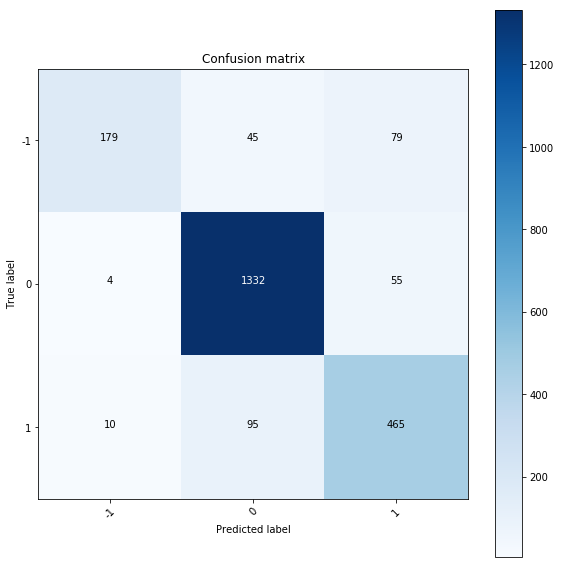

In [93]:
alpha=0.1
binary = True
ngram_range = (1,3)
use_fs = False
use_idf = True

pipeline = [('vectorizer', CountVectorizer(ngram_range=ngram_range, binary=binary))]
if use_fs: pipeline.append(('feature-selector', SelectFromModel(ExtraTreesClassifier())))
if use_idf: pipeline.append(('transformer', TfidfTransformer()))
pipeline.append(('estimator', MultinomialNB(alpha)))
    
classifier = Pipeline(pipeline)
classifier = classifier.fit(X, y)

accuracy, cm = cross_validate(classifier, X, y, n_splits=10, shuffle=True, random_state=None)
plot_confusion_matrix(cm, classes)
print("Average Accuracy = %0.3f." % (accuracy,))

## NBSVM

Fold 01 accuracy = 0.908.
Fold 02 accuracy = 0.890.
Fold 03 accuracy = 0.890.
Fold 04 accuracy = 0.894.
Fold 05 accuracy = 0.898.
Fold 06 accuracy = 0.867.
Fold 07 accuracy = 0.907.
Fold 08 accuracy = 0.916.
Fold 09 accuracy = 0.898.
Fold 10 accuracy = 0.929.
Average Accuracy = 0.900.


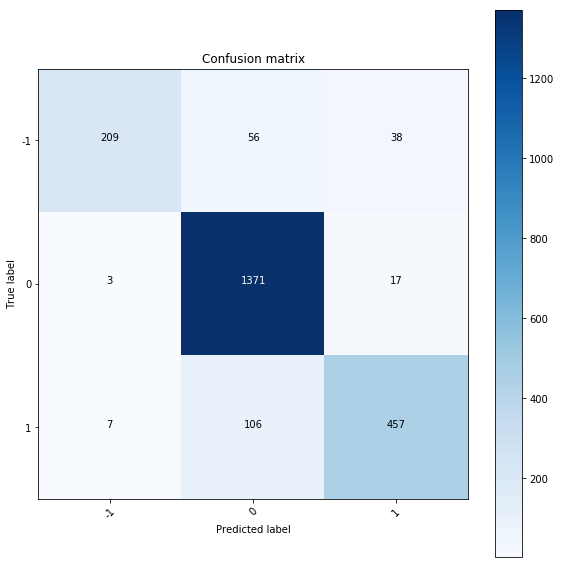

In [94]:
alpha=0.3
binary = True
ngram_range = (1,3)
use_fs = False
use_idf = False

pipeline = [('vectorizer', CountVectorizer(ngram_range=ngram_range, binary=binary))]
if use_fs: pipeline.append(('feature-selector', SelectFromModel(ExtraTreesClassifier())))
if use_idf: pipeline.append(('transformer', TfidfTransformer()))
pipeline.append(('estimator', NBSVM(alpha=alpha, C=1.0, beta=0.25)))
    
classifier = Pipeline(pipeline)
classifier = classifier.fit(X, y)

accuracy, cm = cross_validate(classifier, X, y, n_splits=10, shuffle=True, random_state=None)
plot_confusion_matrix(cm, classes)
print("Average Accuracy = %0.3f." % (accuracy,))